In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as md
import matplotlib.ticker as ticker

In [175]:
def plot_time_series(cw_csv_file: str, tester_csv_file: str, includes_healthy_hosts=False, suptitle=""):
  df_cw = pd.read_csv(cw_csv_file)
  df_tester = pd.read_csv(tester_csv_file)

  df_cw['timestamp'] = pd.to_datetime(df_cw['timestamp'], format='%Y/%m/%d %H:%M:%S')
  df_tester['timestamp'] = pd.to_datetime(df_tester['timestamp'], format='%Y/%m/%d %H:%M:%S')

  df_cw.set_index('timestamp', inplace=True)
  df_tester.set_index('timestamp', inplace=True)

  merged_df = pd.merge(df_cw,
                      df_tester,
                      on='timestamp',
                      how='outer')

  merged_df.sort_index(inplace=True)

  merged_df.fillna(method='ffill', inplace=True)
  merged_df.fillna(value=0.0, inplace=True)

  desired_start_time = pd.to_datetime('00:00')
  actual_start_time = merged_df.index.min()
  time_difference = desired_start_time - actual_start_time
  merged_df.index += time_difference

  xfmt = md.DateFormatter('%M:%S')

  fig, axs = plt.subplots(nrows=2, figsize=(7, 5))
  merged_df[["connectedPlayers", "AveragePlayerCount"]].plot.line(ax = axs[0])
  axs[0].xaxis.set_major_formatter(xfmt)
  axs[0].set_title("Players")
  axs[0].set_xlabel('Time in minutes:seconds')
  axs[0].legend(labels=["Total connected players", "Avg no. of players per server"])

  if includes_healthy_hosts:
    instances_columns = merged_df[["HealthyHostCount", "Instances"]]
    labels = ["Healthy instances", "Running instances"]
  else:
    instances_columns = merged_df[["DesiredCapacity", "Instances"]]
    labels = ["Desired instances", "Running instances"]

  instances_columns.plot.line(ax = axs[1])
  axs[1].xaxis.set_major_formatter(xfmt)
  axs[1].set_title("EC2 Instances")
  axs[1].set_xlabel('Time in minutes:seconds') 
  axs[1].yaxis.set_major_locator(ticker.MultipleLocator(base=1))
  axs[1].legend(labels=labels)

  if suptitle != "":
    fig.suptitle(suptitle)
  fig.tight_layout()
  plt.show()

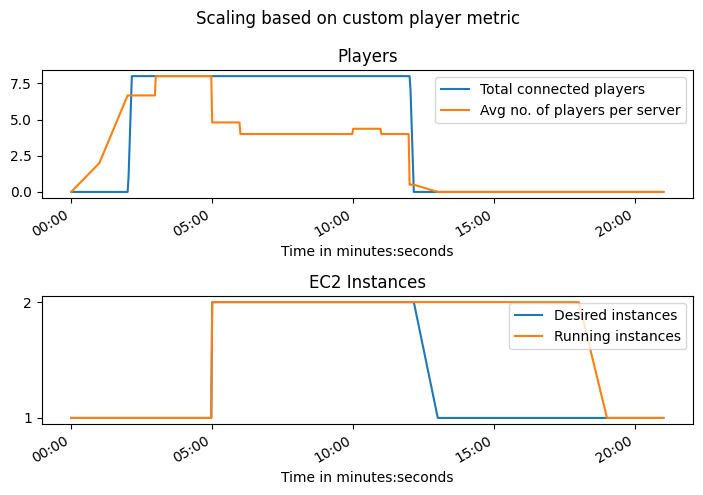

In [173]:
plot_time_series('cloudwatch-metric-1.csv', 'loadtest-metric-1.csv', suptitle="Scaling based on custom player metric")

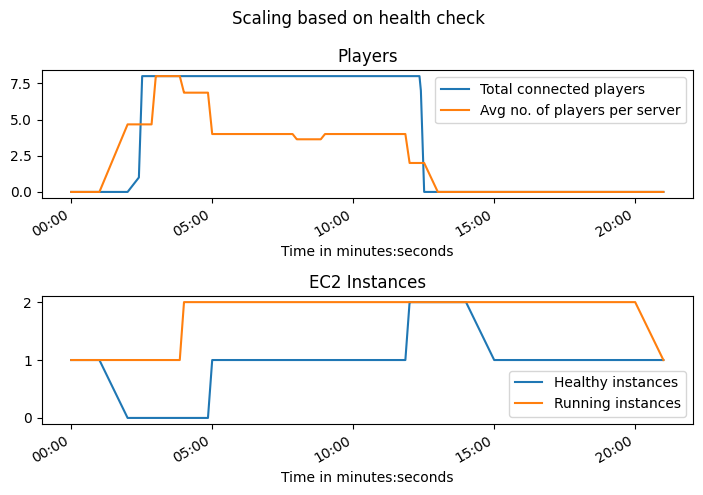

In [176]:
plot_time_series('cloudwatch-healthcheck-1.csv', 'loadtest-healthcheck-1.csv', includes_healthy_hosts=True, suptitle="Scaling based on health check")